In [21]:
import kagglehub
from keras.src.backend.jax.nn import sigmoid

path = kagglehub.dataset_download("mssmartypants/rice-type-classification")

print("Path to dataset files:", path)

import os
path = "/Users/gauravkumar/.cache/kagglehub/datasets/mssmartypants/rice-type-classification/versions/2"
print(os.listdir(path))


Path to dataset files: /Users/gauravkumar/.cache/kagglehub/datasets/mssmartypants/rice-type-classification/versions/2
['riceClassification.csv']


In [147]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
#device = "mps"

In [148]:
data_df = pd.read_csv("/Users/gauravkumar/.cache/kagglehub/datasets/mssmartypants/rice-type-classification/versions/2/riceClassification.csv")

In [149]:
data_df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [150]:
data_df.dropna(inplace=True)
data_df.drop(['id'], axis=1, inplace=True)

In [151]:
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [152]:
print(data_df["Class"].value_counts())

Class
1    9985
0    8200
Name: count, dtype: int64


In [153]:
orginal_df = data_df.copy()

for columns in data_df.columns: #normalisation
    data_df[columns]= data_df[columns]/data_df[columns].abs().max()

In [154]:
X = np.array(data_df.iloc[:,:-1])
y = np.array(data_df.iloc[:,-1])

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3)

In [156]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [157]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(12729, 10) (2728, 10) (12729,) (2728,)


In [158]:
    class Dataset(Dataset):
        def __init__(self, X, y):
            self.X = torch.tensor(X, dtype=torch.float32)
            self.y = torch.tensor(y, dtype=torch.float32)
        def __len__(self):
            return len(self.X)
        def __getitem__(self, idx):
            return self.X[idx], self.y[idx]


In [159]:
training_set = Dataset(X_train, y_train)
validation_set = Dataset(X_val, y_val)
test_set = Dataset(X_test, y_test)


In [219]:
training_loader = DataLoader(training_set, batch_size=8, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=8, shuffle=True)
test_loader = DataLoader(test_set, batch_size=8, shuffle=True)


In [220]:
hidden_layer_neurons = 10
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.input_layer = nn.Linear(X_train.shape[1], hidden_layer_neurons)
        self.linear = nn.Linear(hidden_layer_neurons, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self,x):
        x = self.input_layer(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

model = MyModel()

In [221]:
summary(model, (X_train.shape[1], hidden_layer_neurons))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 10, 10]             110
            Linear-2                [-1, 10, 1]              11
           Sigmoid-3                [-1, 10, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [261]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=1e-3)

In [262]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []
epochs = 20
for epoch in range(epochs):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0

    for data in training_loader:
        input, label = data

        prediction = model(input).squeeze(1)
        batch_loss = criterion(prediction, label)
        total_loss_train += batch_loss.item()
        accuracy = ((prediction).round() == label).sum().item()
        total_acc_train += accuracy

        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    with torch.no_grad():
        for data in validation_loader:
            input, label = data
            prediction = model(input).squeeze(1)
            batch_loss = criterion(prediction, label)
            total_loss_val = batch_loss.item()
            accuracy = (prediction.round() == label).sum().item()

            total_acc_val += accuracy

    total_loss_train_plot.append(round((total_loss_train)/1000,4))
    total_loss_validation_plot.append(round((total_loss_val)/1000,4))

    total_acc_train_plot.append(round(total_acc_train/training_set.__len__()*100,4))
    total_acc_validation_plot.append(round(total_acc_val/validation_set.__len__()*100,4))
    print(f"Current Epoch: {epoch+1}")
    print(f"Total Loss: {round((total_loss_train),4)}")
    print("="*25)
    print(f"Total Accuracy: {round(total_acc_train/training_set.__len__()*100,4)}")
    print("="*25)
    print(f"Total Validation Accuracy: {round(total_acc_val/validation_set.__len__()*100,4)} ")



Current Epoch: 1
Total Loss: 60.9082
Total Accuracy: 98.6645
Total Validation Accuracy: 98.6437 
Current Epoch: 2
Total Loss: 61.0505
Total Accuracy: 98.6959
Total Validation Accuracy: 98.6804 
Current Epoch: 3
Total Loss: 60.9676
Total Accuracy: 98.7273
Total Validation Accuracy: 98.717 
Current Epoch: 4
Total Loss: 60.9783
Total Accuracy: 98.6488
Total Validation Accuracy: 98.717 
Current Epoch: 5
Total Loss: 60.8646
Total Accuracy: 98.6723
Total Validation Accuracy: 98.717 
Current Epoch: 6
Total Loss: 60.9242
Total Accuracy: 98.7116
Total Validation Accuracy: 98.717 
Current Epoch: 7
Total Loss: 60.8099
Total Accuracy: 98.6723
Total Validation Accuracy: 98.717 
Current Epoch: 8
Total Loss: 60.9908
Total Accuracy: 98.688
Total Validation Accuracy: 98.6804 
Current Epoch: 9
Total Loss: 60.9659
Total Accuracy: 98.6802
Total Validation Accuracy: 98.717 
Current Epoch: 10
Total Loss: 60.6951
Total Accuracy: 98.688
Total Validation Accuracy: 98.6437 
Current Epoch: 11
Total Loss: 61.2717

In [263]:
with torch.no_grad():
    total_loss_test = 0
    total_accuracy_test = 0
    for data in test_loader:
        inputs, label = data
        prediction = model(inputs).squeeze(1)
        batch_loss_test = criterion(prediction, label)
        total_loss_test = batch_loss_test
        accuracy = (prediction.round() == label).sum().item()
        total_accuracy_test += accuracy

print("Accuracy:", round(total_accuracy_test/test_set.__len__()*100,4))


Accuracy: 98.7903


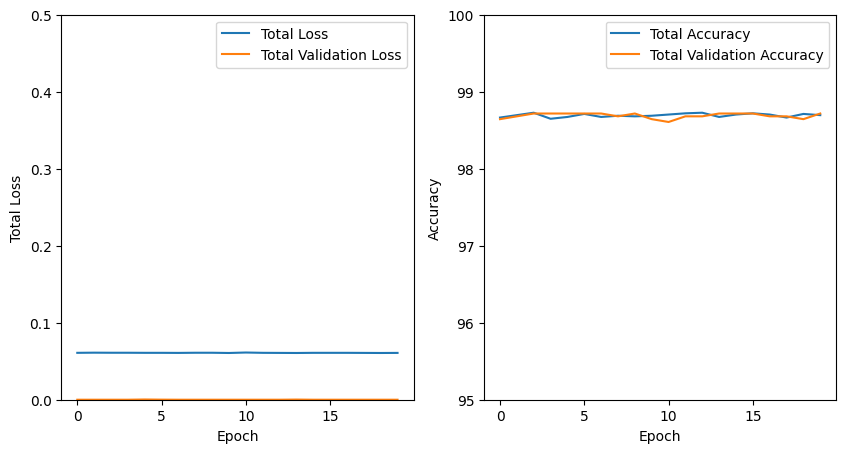

In [267]:
# visulisation

fig, axs = plt.subplots(nrows = 1, ncols= 2, figsize=(10,5))
axs[0].plot(total_loss_train_plot, label="Total Loss")
axs[0].plot(total_loss_validation_plot, label="Total Validation Loss")

axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Total Loss")
axs[0].set_ylim([0,0.5])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label="Total Accuracy")
axs[1].plot(total_acc_validation_plot, label="Total Validation Accuracy")

axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].set_ylim([95,100])
axs[1].legend()

plt.show()